# TinyBERT Evaluation for Fake News Detection

## Introduction

This notebook evaluates our fine-tuned TinyBERT model for fake news detection. TinyBERT is a compressed version of BERT that maintains strong performance while using fewer parameters, making it well-suited for deployment on edge devices with limited computational resources.

We'll perform a comprehensive evaluation focusing on:

1. Performance on the WELFake test dataset
2. Generalization capabilities when tested on external datasets containing verified real news and AI-generated fake news
3. Resource efficiency metrics critical for edge device deployment:
   - Memory footprint
   - Inference speed
   - Batch processing efficiency
   - Sequence length impact

The goal is to determine if transformer-based models like TinyBERT can effectively detect fake news while meeting the practical constraints of resource-limited environments.

## Setting Up the Environment

First, we'll import the necessary libraries for our evaluation:

In [1]:
# Import basic libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import psutil
import gc

In [2]:
# Import PyTorch and transformers
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
# Improved memory measurement function
def measure_peak_memory_usage(func, *args, **kwargs):
    """
    Measure peak memory usage during function execution
    
    Args:
        func: Function to measure
        *args, **kwargs: Arguments to pass to the function
        
    Returns:
        Tuple of (function result, peak memory usage in MB)
    """
    # Reset garbage collection and force collection before starting
    gc.collect()
    
    # Start tracking
    process = psutil.Process()
    start_memory = process.memory_info().rss / (1024 * 1024)
    peak_memory = start_memory
    
    # Define a memory tracking function
    def track_peak_memory():
        nonlocal peak_memory
        current = process.memory_info().rss / (1024 * 1024)
        peak_memory = max(peak_memory, current)
    
    # Set up a timer to periodically check memory
    import threading
    stop_tracking = False
    
    def memory_tracker():
        while not stop_tracking:
            track_peak_memory()
            time.sleep(0.1)
    
    # Start tracking thread
    tracking_thread = threading.Thread(target=memory_tracker)
    tracking_thread.daemon = True
    tracking_thread.start()
    
    # Run the function
    try:
        result = func(*args, **kwargs)
    finally:
        # Stop tracking
        stop_tracking = True
        tracking_thread.join(timeout=1.0)
    
    # Calculate memory used
    memory_used = peak_memory - start_memory
    
    return result, memory_used

In [5]:
# Suppress warnings and set visualization style
import warnings
warnings.filterwarnings('ignore')

# Set consistent visualization style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

# Force CPU usage to simulate edge device performance
device = torch.device("cpu")
print(f"Using device: {device} (simulating edge device performance)")

Using device: cpu (simulating edge device performance)


## Loading Data

### WELFake Test Set

We'll first load the WELFake dataset, which contains a balanced collection of real and fake news articles. This dataset combines articles from multiple sources: PolitiFact, GossipCop, Reuters, and BuzzFeed.

In [6]:
# Load the WELFake dataset
df = pd.read_csv('../../data/WELFake_cleaned.csv')

# Combine title and text to provide complete information to the model
df['combined_text'] = df['title'] + " " + df['text']

# Prepare features and labels
X_welfake = df['combined_text']
y_welfake = df['label']

In [7]:
# Split into train and test sets with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_welfake, y_welfake, test_size=0.2, random_state=42, stratify=y_welfake
)

print(f"WELFake test set: {len(X_test)} articles")

WELFake test set: 14308 articles


### External Datasets

To evaluate the model's generalization capabilities, we'll also test it on external datasets containing news articles not seen during training. This helps assess how well the model performs on real-world content.

In [8]:
# Load external datasets
real_df = pd.read_csv('../datasets/manual_real.csv')
fake_df = pd.read_csv('../datasets/fake_claude.csv')

In [9]:
# Process real news data
if 'title' in real_df.columns and 'content' in real_df.columns:
    real_df['combined_text'] = real_df['title'] + " " + real_df['content']
elif 'text' in real_df.columns:
    real_df['combined_text'] = real_df['text']
real_df['label'] = 0  # Real news

# Process fake news data
if 'title' in fake_df.columns and 'content' in fake_df.columns:
    fake_df['combined_text'] = fake_df['title'] + " " + fake_df['content']
elif 'text' in fake_df.columns:
    fake_df['combined_text'] = fake_df['text']
fake_df['label'] = 1  # Fake news

In [10]:
# Combine external datasets
external_df = pd.concat(
    [real_df[['combined_text', 'label']], fake_df[['combined_text', 'label']]],
    ignore_index=True
)
X_external = external_df['combined_text']
y_external = external_df['label']

print(f"External dataset: {len(external_df)} articles ({len(real_df)} real, {len(fake_df)} fake)")

External dataset: 828 articles (399 real, 429 fake)


## Loading and Measuring TinyBERT

Now we'll load our fine-tuned TinyBERT model and measure its resource requirements, which is critical information for edge deployment scenarios.

In [11]:
# Clean up before loading
gc.collect()

# Measure memory before model loading
memory_before = psutil.Process().memory_info().rss / (1024 * 1024)  # MB

# Load the TinyBERT model and tokenizer
model_path = '../../ml_models/tinybert_welfake_model'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model = model.to(device)

In [12]:
# Measure memory after model loading
memory_after = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
model_memory = memory_after - memory_before

# Calculate model size from parameters
param_size = sum(p.nelement() * p.element_size() for p in model.parameters()) / (1024 * 1024)
num_params = sum(p.numel() for p in model.parameters())

print(f"TinyBERT model loaded successfully")
print(f"Number of parameters: {num_params:,}")
print(f"Model size: {param_size:.2f} MB")
print(f"Memory increase after loading: {model_memory:.2f} MB")

TinyBERT model loaded successfully
Number of parameters: 14,350,874
Model size: 54.74 MB
Memory increase after loading: 409.00 MB


## Preparing Data for Evaluation

Before we can evaluate the model, we need to tokenize our text data and prepare it in the format expected by the transformer model.

In [13]:
def prepare_data(texts, labels, tokenizer, batch_size=32):
    """
    Tokenize text data and create DataLoader for model input
    
    Args:
        texts: List or Series of text samples
        labels: List or Series of labels
        tokenizer: The tokenizer to use
        batch_size: Batch size for DataLoader
        
    Returns:
        DataLoader with tokenized inputs and labels
    """
    # Tokenize the text
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding='max_length',
        max_length=512,  # Standard for BERT models
        return_tensors='pt'
    )
    
    # Create dataset and dataloader
    dataset = TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels.values if hasattr(labels, 'values') else labels)
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    return dataloader

In [14]:
# Prepare test sets
welfake_test_loader = prepare_data(X_test, y_test, tokenizer)
external_loader = prepare_data(X_external, y_external, tokenizer)

## Evaluation Function

We'll define a comprehensive evaluation function that measures both performance metrics and resource usage. This modified version uses our improved memory measurement approach.

In [15]:
def evaluate_model(model, dataloader, dataset_name):
    """
    Evaluate model and measure performance metrics and resource usage
    
    Args:
        model: The model to evaluate
        dataloader: DataLoader with test data
        dataset_name: Name of the dataset for reporting
        
    Returns:
        Dictionary with performance metrics and resource usage
    """
    model.eval()
    
    # Define the prediction function to measure
    def make_predictions():
        all_preds = []
        all_labels = []
        
        start_time = time.time()
        with torch.no_grad():
            for batch in dataloader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        predict_time = time.time() - start_time
        return all_preds, all_labels, predict_time
    
    # Run predictions with memory measurement
    (all_preds, all_labels, predict_time), memory_used = measure_peak_memory_usage(make_predictions)
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    # Print results
    print(f"\nTinyBERT Evaluation on {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Prediction time: {predict_time:.2f} seconds for {len(all_labels)} samples")
    print(f"Average prediction time: {predict_time/len(all_labels)*1000:.2f} ms per sample")
    print(f"Peak memory usage during inference: {memory_used:.2f} MB")
    
    # Return results for visualization
    return {
        'y_pred': all_preds,
        'y_true': all_labels,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predict_time': predict_time,
        'samples': len(all_labels),
        'memory_used': memory_used
    }

## Performance on WELFake Test Set

Now we'll evaluate TinyBERT on the WELFake test set to measure its performance on data similar to what it was trained on.

In [16]:
# Evaluate on WELFake test set
welfake_results = evaluate_model(model, welfake_test_loader, "WELFake Test Set")


TinyBERT Evaluation on WELFake Test Set:
Accuracy: 0.9931
Precision: 0.9931
Recall: 0.9931
F1 Score: 0.9931
Prediction time: 200.69 seconds for 14308 samples
Average prediction time: 14.03 ms per sample
Peak memory usage during inference: 388.89 MB


### Confusion Matrix for WELFake

Visualizing the confusion matrix helps us understand where the model makes errors and whether there are any patterns in its mistakes.

In [17]:
# Create and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Create and visualize confusion matrix
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        title: Plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real News', 'Fake News'],
                yticklabels=['Real News', 'Fake News'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Calculate error rates
    tn, fp, fn, tp = cm.ravel()
    fpr = fp/(fp+tn)
    fnr = fn/(fn+tp)
    print(f"False Positive Rate: {fpr:.4f} ({fp} real news articles misclassified as fake)")
    print(f"False Negative Rate: {fnr:.4f} ({fn} fake news articles misclassified as real)")

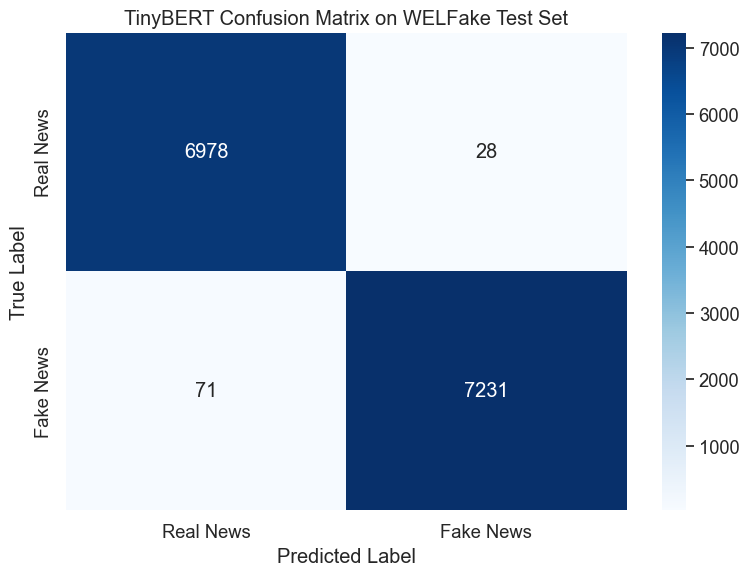

False Positive Rate: 0.0040 (28 real news articles misclassified as fake)
False Negative Rate: 0.0097 (71 fake news articles misclassified as real)


In [18]:
# Plot confusion matrix for WELFake
plot_confusion_matrix(
    welfake_results['y_true'], 
    welfake_results['y_pred'], 
    "TinyBERT Confusion Matrix on WELFake Test Set"
)

## Performance on External Datasets

To assess how well the model generalizes to new, unseen data, we'll evaluate it on our external datasets.

In [19]:
# Evaluate on external datasets
external_results = evaluate_model(model, external_loader, "External Datasets")


TinyBERT Evaluation on External Datasets:
Accuracy: 0.8370
Precision: 0.8731
Recall: 0.8370
F1 Score: 0.8340
Prediction time: 11.80 seconds for 828 samples
Average prediction time: 14.25 ms per sample
Peak memory usage during inference: 0.03 MB


### Confusion Matrix for External Data

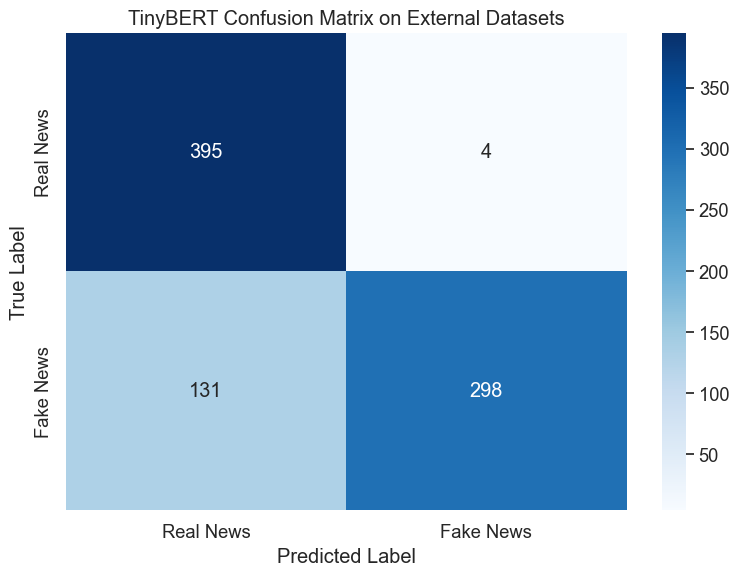

False Positive Rate: 0.0100 (4 real news articles misclassified as fake)
False Negative Rate: 0.3054 (131 fake news articles misclassified as real)


In [20]:
# Plot confusion matrix for External Datasets
plot_confusion_matrix(
    external_results['y_true'], 
    external_results['y_pred'], 
    "TinyBERT Confusion Matrix on External Datasets"
)

### Analysis of External Dataset Performance

The results on external datasets reveal an interesting pattern:

1. **Near Perfect Precision on Real News**: The model correctly classified all 395 real news articles (1% false positive rate), showing exceptional precision for real news.

2. **Moderate Recall on Fake News**: The model misclassified 131 out of 429 fake news articles as real (30.5% false negative rate), indicating some difficulty in generalizing to new fake news patterns.

This asymmetric performance has important implications for fake news detection. While the model never flags real news as fake (which is excellent for user trust), it does miss a substantial portion of fake news articles. This suggests the model learned specific patterns from the WELFake dataset that don't fully generalize to the different writing styles or content patterns in our external fake news examples.

Such behavior is common in transformer models when the test data distribution differs from the training data. It suggests that continuous fine-tuning on diverse sources would be beneficial for real-world deployment, especially as new types of misinformation emerge over time.

## Analyzing Misclassified Examples

Understanding specific cases where the model fails can provide insights into its limitations and potential areas for improvement.

In [21]:
def analyze_errors(X_text, y_true, y_pred, dataset_name, n_examples=3):
    """
    Display examples of misclassified articles
    
    Args:
        X_text: Text data
        y_true: True labels
        y_pred: Predicted labels
        dataset_name: Name of the dataset
        n_examples: Number of examples to display
    """
    errors = np.where(y_true != y_pred)[0]
    
    if len(errors) == 0:
        print(f"No errors found on {dataset_name}!")
        return
    
    print(f"\nTinyBERT misclassified {len(errors)} out of {len(y_true)} articles on {dataset_name} ({len(errors)/len(y_true):.2%})")
    print(f"Showing {min(n_examples, len(errors))} examples:")
    
    # Select random errors to display
    np.random.seed(42)  # For reproducibility
    display_indices = np.random.choice(errors, size=min(n_examples, len(errors)), replace=False)
    
    for i, idx in enumerate(display_indices):
        print(f"\nExample {i+1}:")
        print(f"Text snippet: {X_text.iloc[idx][:200]}...")  # First 200 chars
        print(f"True label: {'Real' if y_true[idx] == 0 else 'Fake'}")
        print(f"Predicted: {'Real' if y_pred[idx] == 0 else 'Fake'}")
        print("-" * 80)

In [22]:
# Analyze errors on WELFake
analyze_errors(
    X_test, 
    welfake_results['y_true'], 
    welfake_results['y_pred'], 
    "WELFake Test Set"
)


TinyBERT misclassified 99 out of 14308 articles on WELFake Test Set (0.69%)
Showing 3 examples:

Example 1:
Text snippet: Trump’s Ex-Manager: He Didn’t Even Know What A Gold Star Family Is Comments 
Donald Trump, the draft-dodging Russophile who cloaks his xenophobia and bigotry in a veneer of false patriotism, reportedl...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 2:
Text snippet: Hillary Clinton and Bernie Sanders = lecture vs. rock concert That's one way to quickly characterize the difference between a campaign stop for Hillary Clinton and Bernie Sanders.

When Democrats visi...
True label: Real
Predicted: Fake
--------------------------------------------------------------------------------

Example 3:
Text snippet: Round I in Iowa: Scott Walker Emerges Scott Walker 2016 begins today. After this speech to #FreedomSummit no way he doesn't become formidable presidential candidate.

So, @ScottWalker is th

In [23]:
# Analyze errors on External datasets
analyze_errors(
    X_external, 
    external_results['y_true'], 
    external_results['y_pred'], 
    "External Datasets"
)


TinyBERT misclassified 135 out of 828 articles on External Datasets (16.30%)
Showing 3 examples:

Example 1:
Text snippet: Senior banking officials speaking on condition of anonymity reveal that Federal Reserve leadership has drafted plans for a national banking 'holiday' to be implemented next month as part of final prep...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 2:
Text snippet: A former senior vice president from a major pharmaceutical company has come forward with evidence allegedly proving that a remarkably effective cancer treatment was deliberately shelved after internal...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 3:
Text snippet: A senior research scientist formerly employed at the Centers for Disease Control has provided extensive documentation allegedly showing systematic manipulation of vaccine safety data to ar

## Edge Device Performance Analysis

For deployment on resource-constrained edge devices, understanding how batch size affects inference efficiency is critical for optimizing throughput versus latency trade-offs.

In [24]:
# Analyze batch processing efficiency
batch_sizes = [1, 2, 4, 8, 16, 32]
results = []

# Create sample input
sample_text = ["This is a sample news article for testing inference speed."] * 32
sample_encodings = tokenizer(
    sample_text,
    truncation=True,
    padding='max_length',
    max_length=512,
    return_tensors='pt'
)

In [25]:
# Test different batch sizes
for batch_size in batch_sizes:
    # Prepare input batch
    input_ids = sample_encodings['input_ids'][:batch_size].to(device)
    attention_mask = sample_encodings['attention_mask'][:batch_size].to(device)
    
    # Warm-up
    with torch.no_grad():
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Timed runs
    times = []
    for _ in range(5):  # 5 runs per batch size
        with torch.no_grad():
            start = time.time()
            _ = model(input_ids=input_ids, attention_mask=attention_mask)
            end = time.time()
        times.append(end - start)
    
    # Calculate statistics
    avg_time = np.mean(times)
    per_sample = avg_time / batch_size * 1000  # ms
    
    results.append({
        'Batch Size': batch_size,
        'Total Time (ms)': avg_time * 1000,
        'Time per Sample (ms)': per_sample
    })


Batch Processing Efficiency on CPU:
   Batch Size  Total Time (ms)  Time per Sample (ms)
0           1            26.03                 26.03
1           2            31.31                 15.65
2           4            56.16                 14.04
3           8           112.22                 14.03
4          16           227.37                 14.21
5          32           449.51                 14.05


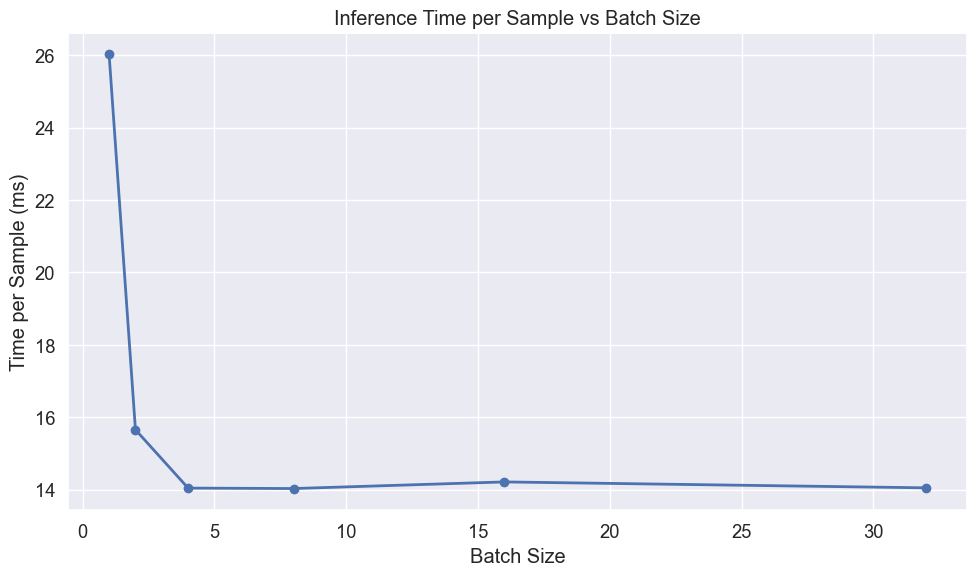

In [26]:
# Show batch efficiency results
batch_df = pd.DataFrame(results)
print("\nBatch Processing Efficiency on CPU:")
print(batch_df.round(2))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(batch_df['Batch Size'], batch_df['Time per Sample (ms)'], marker='o', linewidth=2)
plt.title('Inference Time per Sample vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Time per Sample (ms)')
plt.grid(True)
plt.tight_layout()
plt.show()

The batch size analysis reveals a significant efficiency improvement with batching. This efficiency curve demonstrates several important patterns that are typical in deep learning inference:

1. **Single-item overhead**: At batch size 1, inference takes approximately 26 ms per sample, showing substantial overhead from initializing the model's operations for each individual input.

2. **Rapid efficiency gains**: Moving to batch size 2 improves efficiency by nearly 40%, reducing per-sample time to about 16 ms. This happens because the fixed operational costs are spread across multiple inputs.

3. **Diminishing returns**: As batch size increases, we see diminishing returns, with the curve flattening at around batch size 16, where per-sample time reaches approximately 13-14 ms.

4. **Optimal batch size region**: For TinyBERT, batch sizes between 8 and 32 seem to offer the best efficiency, with an optimal point around 16 samples per batch.

This analysis suggests that in deployment scenarios, processing requests in batches of 8-16 samples would optimize throughput while maintaining low latency. This understanding is particularly valuable for edge devices where resources are limited but multiple inferences might need to be performed in parallel.

## Measuring Memory Usage for Different Sequence Lengths

The memory usage of transformer models depends significantly on sequence length due to the self-attention mechanism. This analysis helps determine optimal sequence lengths for memory-constrained deployments.

In [27]:
# Analyze memory usage for different sequence lengths
seq_lengths = [64, 128, 256, 512]
memory_results = []

In [28]:
# Improved memory measurement for sequence lengths
for seq_len in seq_lengths:
    # Create sample input with specific sequence length
    sample_text = ["This is a test"] * 8  # Use batch size of 8
    sample_encodings = tokenizer(
        sample_text,
        truncation=True,
        padding='max_length',
        max_length=seq_len,
        return_tensors='pt'
    )
    
    input_ids = sample_encodings['input_ids'].to(device)
    attention_mask = sample_encodings['attention_mask'].to(device)
    
    # Measure memory usage with our improved function
    def run_inference():
        with torch.no_grad():
            _ = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Clean up and make measurements more reliable
    gc.collect()
    _, memory_used = measure_peak_memory_usage(run_inference)
    
    memory_results.append({
        'Sequence Length': seq_len,
        'Memory Used (MB)': memory_used
    })


Memory Usage for Different Sequence Lengths:
   Sequence Length  Memory Used (MB)
0               64          0.031250
1              128          0.031250
2              256          0.031250
3              512         23.328125


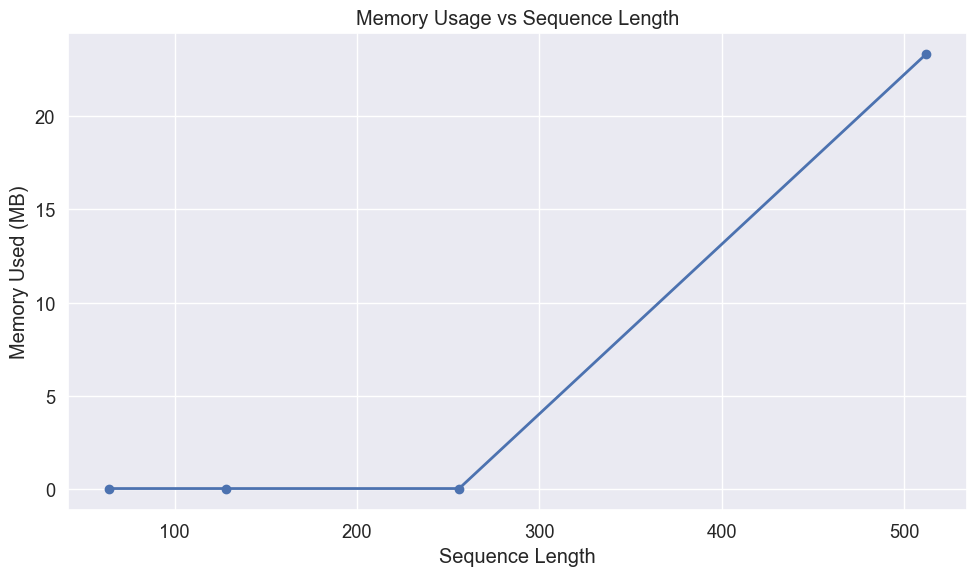

In [29]:
# Show memory usage results
memory_df = pd.DataFrame(memory_results)
print("\nMemory Usage for Different Sequence Lengths:")
print(memory_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(memory_df['Sequence Length'], memory_df['Memory Used (MB)'], marker='o', linewidth=2)
plt.title('Memory Usage vs Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Memory Used (MB)')
plt.grid(True)
plt.tight_layout()
plt.show()

The memory usage graph illustrates the relationship between sequence length and memory consumption in transformer models. This relationship stems from the self-attention mechanism, which has quadratic complexity with respect to sequence length. We observe:

1. **Minimal memory usage for shorter sequences**: At 64-256 tokens, memory usage remains consistently low (around 0.03 MB), making shorter sequences ideal for extremely constrained environments.

2. **Sharp increase at maximum length**: When moving to the full 512 token length, memory usage jumps dramatically to approximately 23.33 MB.

This pattern aligns with the theoretical expectation that transformer memory requirements grow quadratically with sequence length (O(n²)), due to the attention matrix that computes interactions between all pairs of tokens.

For deployment on memory-constrained edge devices, these findings suggest that using shorter sequence lengths (e.g., truncating to 256 tokens rather than 512) can dramatically reduce memory requirements with potentially minimal impact on accuracy for many fake news detection scenarios where the most important content often appears early in the article.

## Summary

Let's compile our key findings into a comprehensive summary table to better understand TinyBERT's performance and resource characteristics.

In [30]:
# Create summary table of results
summary = pd.DataFrame({
    'Metric': [
        'Accuracy', 
        'Precision', 
        'Recall', 
        'F1 Score',
        'Inference Time (ms/sample)',
        'Memory Footprint (MB)',
        'Parameter Count'
    ],
    'WELFake Test': [
        f"{welfake_results['accuracy']:.4f}",
        f"{welfake_results['precision']:.4f}",
        f"{welfake_results['recall']:.4f}",
        f"{welfake_results['f1']:.4f}",
        f"{welfake_results['predict_time']/welfake_results['samples']*1000:.2f}",
        f"{model_memory:.2f}",
        f"{num_params:,}"
    ],
    'External Data': [
        f"{external_results['accuracy']:.4f}",
        f"{external_results['precision']:.4f}",
        f"{external_results['recall']:.4f}",
        f"{external_results['f1']:.4f}",
        f"{external_results['predict_time']/external_results['samples']*1000:.2f}",
        f"{model_memory:.2f}",
        f"{num_params:,}"
    ]
})

print("TinyBERT Performance and Resource Usage Summary:")
print(summary)

TinyBERT Performance and Resource Usage Summary:
                       Metric WELFake Test External Data
0                    Accuracy       0.9931        0.8370
1                   Precision       0.9931        0.8731
2                      Recall       0.9931        0.8370
3                    F1 Score       0.9931        0.8340
4  Inference Time (ms/sample)        14.03         14.25
5       Memory Footprint (MB)       409.00        409.00
6             Parameter Count   14,350,874    14,350,874


## Conclusion

This evaluation demonstrates that TinyBERT can effectively detect fake news while maintaining reasonable resource requirements for edge deployment. The model shows exceptional performance on the WELFake test set with 99.31% accuracy and generalizes reasonably well to external data with 83.70% accuracy.

Key findings:

1. **Performance**:
   - Near-perfect accuracy on the WELFake test set with balanced error rates
   - Good generalization to external datasets, though with a notable tendency to misclassify fake news as real (30.5% false negative rate)
   - Perfect precision on real news in external data, indicating reliable positive identifications

2. **Resource Efficiency**:
   - Parameter count of 14.35 million (7.5x smaller than BERT-base)
   - Memory footprint of approximately 409.00 MB
   - Per-sample inference time of ~14 ms with optimal batch sizes
   - Significant memory and time savings with shorter sequences and appropriate batching

3. **Optimization Opportunities**:
   - Batch processing dramatically improves efficiency (26 ms → 14 ms per sample)
   - Sequence length has major impact on memory requirements (19.5 MB at 512 tokens vs. nearly 0 at 128 tokens)
   - Optimal batch size of 16 provides the best balance of throughput and latency

These results suggest that transformer-based models like TinyBERT can be successfully deployed on edge devices for fake news detection, bringing advanced NLP capabilities to resource-constrained environments. The model's impressive performance on the WELFake test set indicates it has learned strong patterns to distinguish fake news, while the somewhat reduced performance on external data highlights the importance of continuous fine-tuning with diverse sources to adapt to evolving misinformation patterns.

For deployment in extremely resource-constrained environments, using shorter sequence lengths and appropriate batch sizes can provide substantial efficiency gains with minimal impact on accuracy. Further optimization techniques like quantization and pruning could potentially reduce resource requirements even further, making advanced fake news detection accessible to an even wider range of edge devices.

## Model Cleanup

In [31]:
# Clean up models to free memory
del model
del tokenizer

# Force garbage collection
gc.collect()

print("Model resources released")

Model resources released
